# Introdução

O projeto, da unidade curricular de Inteligência Artificial da Licenciatura em Engenharia de Sistemas Informáticos (2024-25), tem como objetivo o desenvolvimento de um agente inteligente. Este agente será criado e implementado com base nos princípios da Inteligência Artificial, documentando todo o processo num caderno de notas Jupyter.

O trabalho foi realizado pelos seguintes membros:

- João Ponte - 17694
- João Carvalho - 12747

Este projeto procura implementar a resolução de problemas de planeamento de tarefas, abordando restrições fortes e leves, bem como estratégias para a otimização e viabilidade das soluções propostas.

# Planeamento e Resolução do Problema

## Objetivo Geral
Resolver o problema de planeamento de tarefas descrito no ficheiro **p01_dataset_8.txt**, respeitando:
- **Restrições de precedência**: As tarefas devem ser executadas na ordem correta.
- **Disponibilidade de recursos**: Garantir que os recursos disponíveis não sejam ultrapassados.
- **Horizonte de tempo**: O cronograma deve caber dentro do limite de tempo definido.

# Instalar dependencias

In [1]:
!pip install networkx matplotlib python-constraint

# Importar bibliotecas

In [2]:
import json
import re
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from itertools import count
from queue import PriorityQueue
from itertools import count

# Analisar e Compreender o Ficheiro

## Estrutura do ficheiro:
1. **General Information**:
   - Número de projetos, tarefas, horizonte de tempo e recursos disponíveis.
2. **Projects Summary**:
   - Resumo do número de tarefas, data de início e prazo final do projeto.
3. **Precedence Relations**:
   - Relações de precedência entre as tarefas (quais tarefas dependem de outras).
4. **Duration and Resources**:
   - Duração e consumo de recursos para cada tarefa.
5. **Resource Availability**:
   - Quantidade total de cada recurso disponível.

# Carregar e ler o ficheiro

In [3]:
# Caminhos dos ficheiros
dataset_path = '/app/datasets/p01_dataset_10.txt'

# Função para ler e processar os ficheiros
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    return data

# Ler o dataset
dataset = read_dataset(dataset_path)

# Extrair e Estruturar as Informações

## Criar funções para processar cada secção:

1. **General Information**:
   - Extrair o número de projetos (`projects`), tarefas (`jobs`), horizonte (`horizon`) e tipos de recursos (`resources`).
   - Exemplo:
     ```python
     {
         "projects": 1,
         "jobs": 8,
         "horizon": 20,
         "resources": {
             "renewable": [2, "R"],
             "nonrenewable": [0, "N"],
             "doubly_constrained": [0, "D"]
         }
     }
     ```

In [4]:
def parse_general_information(dataset):
    general_info = {}
    resources = []

    # Encontrar o bloco "General Information"
    start_index = dataset.index("#General Information\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 1:end_index]

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if ":" in line:
            key, value = map(str.strip, line.split(":", 1))
                
            # Detetar recursos
            if re.match(r"^- (renewable|nonrenewable|doubly constrained)", key, re.IGNORECASE):
                parts = value.split()
                resources.append({
                    key.lstrip("- ").strip(): [int(parts[0]), parts[1]]
                })
            else:
                # Converter valores numéricos, se aplicável
                general_info[key] = int(value) if value.isdigit() else value

    # Adicionar os recursos ao resultado final
    if resources:
        general_info["resources"] = resources

    return general_info

# Testar com o ficheiro carregado
general_info = parse_general_information(dataset)
print("Informações Gerais:")
print(json.dumps(general_info, indent=4))

Informações Gerais:
{
    "projects": 1,
    "jobs (incl. supersource/sink )": 12,
    "horizon": 46,
    "resources": [
        {
            "renewable": [
                2,
                "R"
            ]
        },
        {
            "nonrenewable": [
                0,
                "N"
            ]
        },
        {
            "doubly constrained": [
                0,
                "D"
            ]
        }
    ]
}


2. **Projects Summary**:
   - Extrair o número de tarefas, data de início, prazo final e tempo máximo permitido.
   - Exemplo:
     ```python
     {
         "pronr": 1,
         "jobs": 8,
         "rel_date": 0,
         "due_date": 11,
         "tardcost": 0,
         "mpm_time": 11
     }
     ```

In [5]:
def parse_projects_summary(dataset):
    # Encontrar o bloco "Projects Summary"
    start_index = dataset.index("#Projects summary\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 1:end_index]

    # Processar a segunda linha do bloco (após o cabeçalho)
    line = block[1].strip()
    parts = line.split()

    # Mapear os valores para as chaves correspondentes
    summary = {
        "project_number": int(parts[0]),
        "jobs": int(parts[1]),
        "rel_date": int(parts[2]),
        "due_date": int(parts[3]),
        "tard_cost": int(parts[4]),
        "mpm_time": int(parts[5])
    }

    return summary

# Testar com o ficheiro carregado
projects_summary = parse_projects_summary(dataset)
print("Resumo do Projeto:")
print(json.dumps(projects_summary, indent=4))

Resumo do Projeto:
{
    "project_number": 1,
    "jobs": 10,
    "rel_date": 0,
    "due_date": 22,
    "tard_cost": 3,
    "mpm_time": 22
}


3. **Precedence Relations**:
   - Representar as relações de precedência com um grafo direcionado.
   - Exemplo:
     ```python
     "jobnr": [
         {"task": 1, "successors": [2, 3]},
         {"task": 2, "successors": [4]},
         {"task": 3, "successors": [4]},
         {"task": 4, "successors": []},
         ...
     ]
     ```

In [6]:
def parse_precedence_relations(dataset):
    precedence_relations = []

    # Encontrar o bloco "Precedence Relations"
    start_index = dataset.index("#Precedence relations\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 2:end_index]  # Ignorar o cabeçalho da secção

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if not line:
            continue  # Ignorar linhas vazias
        parts = line.split()

        # Extrair informações
        task = int(parts[0])  # Número da tarefa
        successors_count = int(parts[2])  # Número de sucessores
        successors = list(map(int, parts[3:])) if successors_count > 0 else [] # Sucessores

        # Adicionar ao resultado
        precedence_relations.append({
            "task": task,
            "successors": successors
        })

    return precedence_relations

# Testar com o ficheiro carregado
precedence_relations = parse_precedence_relations(dataset)
print("Relações de Precedência:")
print(json.dumps(precedence_relations, indent=4))

Relações de Precedência:
[
    {
        "task": 1,
        "successors": [
            2,
            3,
            4
        ]
    },
    {
        "task": 2,
        "successors": [
            5,
            6
        ]
    },
    {
        "task": 3,
        "successors": [
            10,
            11
        ]
    },
    {
        "task": 4,
        "successors": [
            9
        ]
    },
    {
        "task": 5,
        "successors": [
            7,
            8
        ]
    },
    {
        "task": 6,
        "successors": [
            10,
            11
        ]
    },
    {
        "task": 7,
        "successors": [
            9,
            10
        ]
    },
    {
        "task": 8,
        "successors": [
            9
        ]
    },
    {
        "task": 9,
        "successors": [
            12
        ]
    },
    {
        "task": 10,
        "successors": [
            12
        ]
    },
    {
        "task": 11,
        "successors": [
          

4. **Duration and Resources**:
   - Extrair a duração de cada tarefa e os recursos consumidos.
   - Exemplo:
     ```python
     [
         {"task": 1, "duration": 2, "resources": {"R1": 1, "R2": 0}},
         {"task": 2, "duration": 3, "resources": {"R1": 0, "R2": 1}},
         ...
     ]
     ```

In [7]:
def parse_duration_and_resources(dataset, general_info):
    duration_and_resources = []

    # Encontrar o bloco "Duration and Resources"
    start_index = dataset.index("#Duration and resources\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 2:end_index]  # Ignorar o cabeçalho da secção
    resources = general_info['resources']
    nresources = resources[0]['renewable']

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if not line:
            continue  # Ignorar linhas vazias
        parts = line.split()

        # Extrair informações
        task = int(parts[0])  # Número da tarefa
        duration = int(parts[2])  # Duração
        resources = {     f'R{i + 1}': int(parts[i + 3])     for i in range(nresources[0]) } # Recursos
 

        # Adicionar ao resultado
        duration_and_resources.append({
            "task": task,
            "duration": duration,
            "resources": resources
        })

    return duration_and_resources

# Testar com o ficheiro carregado
duration_and_resources = parse_duration_and_resources(dataset, general_info)
print("Duração e Recursos:")
print(json.dumps(duration_and_resources, indent=4))

Duração e Recursos:
[
    {
        "task": 1,
        "duration": 0,
        "resources": {
            "R1": 0,
            "R2": 0
        }
    },
    {
        "task": 2,
        "duration": 3,
        "resources": {
            "R1": 6,
            "R2": 2
        }
    },
    {
        "task": 3,
        "duration": 1,
        "resources": {
            "R1": 0,
            "R2": 0
        }
    },
    {
        "task": 4,
        "duration": 8,
        "resources": {
            "R1": 4,
            "R2": 0
        }
    },
    {
        "task": 5,
        "duration": 4,
        "resources": {
            "R1": 0,
            "R2": 4
        }
    },
    {
        "task": 6,
        "duration": 4,
        "resources": {
            "R1": 0,
            "R2": 4
        }
    },
    {
        "task": 7,
        "duration": 6,
        "resources": {
            "R1": 2,
            "R2": 0
        }
    },
    {
        "task": 8,
        "duration": 4,
        "resources": {
    

5. **Resource Availability**:
   - Extrair a quantidade total de cada recurso disponível.
   - Exemplo:
     ```python
     {
         "R1": 1,
         "R2": 2
     }
     ```

In [8]:
def parse_resource_availability(dataset):
    resource_availability = {}

    # Encontrar o bloco "Resource Availability"
    start_index = dataset.index("#Resource availability\n")
    end_index = dataset.index("************************************************************************\n", start_index + 1)
    block = dataset[start_index + 2:end_index]  # Ignorar o cabeçalho da secção

    # Processar cada linha do bloco
    for line in block:
        line = line.strip()
        if not line:
            continue  # Ignorar linhas vazias
        parts = line.split()

        # Extrair informações
        resource = parts[0]  # Nome do recurso
        quantity = int(parts[1])  # Quantidade disponível

        # Adicionar ao resultado
        resource_availability[resource] = quantity

    return resource_availability

# Testar com o ficheiro carregado
resource_availability = parse_resource_availability(dataset)
print("Disponibilidade de Recursos:")
print(json.dumps(resource_availability, indent=4))

Disponibilidade de Recursos:
{
    "R1": 6,
    "R2": 4
}


In [9]:
# Processar todas as secções do ficheiro
general_info = parse_general_information(dataset)
projects_summary = parse_projects_summary(dataset)
precedence_relations = parse_precedence_relations(dataset)
duration_and_resources = parse_duration_and_resources(dataset, general_info)
resource_availability = parse_resource_availability(dataset)

# Criar um objeto final com os resultados
parsed_data = {
    "general_info": general_info,
    "projects_summary": projects_summary,
    "precedence_relations": precedence_relations,
    "duration_and_resources": duration_and_resources,
    "resource_availability": resource_availability
}

# Exibir os resultados formatados
print(json.dumps(parsed_data, indent=4))


{
    "general_info": {
        "projects": 1,
        "jobs (incl. supersource/sink )": 12,
        "horizon": 46,
        "resources": [
            {
                "renewable": [
                    2,
                    "R"
                ]
            },
            {
                "nonrenewable": [
                    0,
                    "N"
                ]
            },
            {
                "doubly constrained": [
                    0,
                    "D"
                ]
            }
        ]
    },
    "projects_summary": {
        "project_number": 1,
        "jobs": 10,
        "rel_date": 0,
        "due_date": 22,
        "tard_cost": 3,
        "mpm_time": 22
    },
    "precedence_relations": [
        {
            "task": 1,
            "successors": [
                2,
                3,
                4
            ]
        },
        {
            "task": 2,
            "successors": [
                5,
                6
            

# Representar o Problema em Grafo

1. **Criar um Grafo de Precedências**:
   - Representar as tarefas e dependências com recurso à biblioteca **NetworkX**.
   - Os nós representam as tarefas, e as arestas representam as relações de precedência.

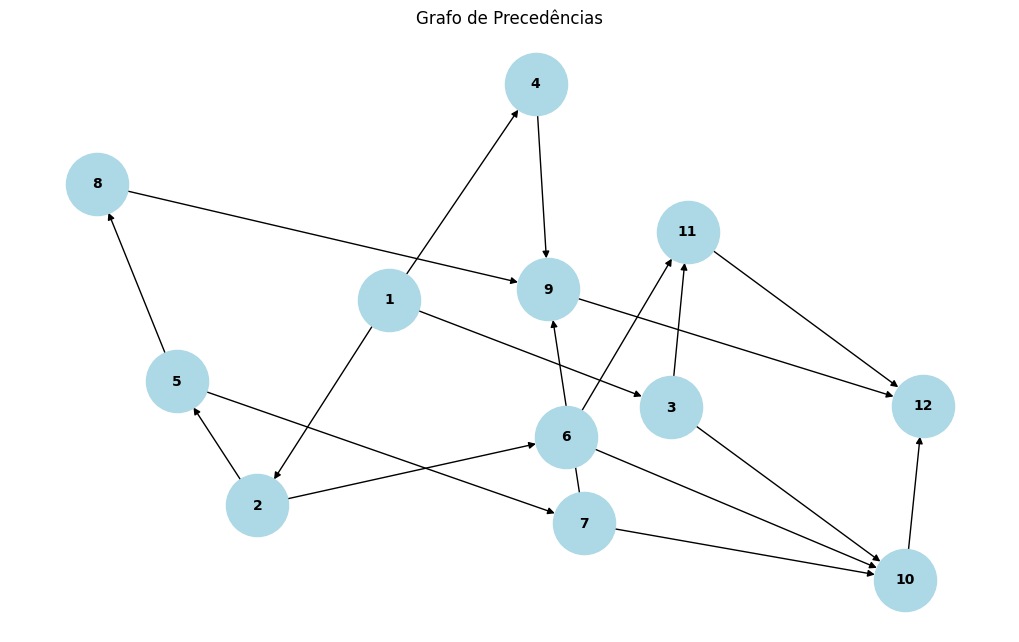

In [10]:
def create_precedence_graph(precedence_relations):
    # Criar o grafo direcionado
    G = nx.DiGraph()

    # Adicionar arestas com base nas relações de precedência
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            G.add_edge(task, successor)

    return G

# Criar o grafo a partir das relações de precedência
precedence_graph = create_precedence_graph(parsed_data["precedence_relations"])

# Visualizar o grafo
plt.figure(figsize=(10, 6))
nx.draw(precedence_graph, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight="bold")
plt.title("Grafo de Precedências")
plt.show()


# Planeamento Básico

## Inicializar o cronograma

In [11]:
def initialize_schedule(horizon, resources):
    """Inicializa o cronograma com slots de tempo e uso de recursos."""
    return {
        "time_slots": [0] * horizon,
        "resource_usage": {r: [0] * horizon for r in resources.keys()}
    }

## Criar um cronograma básico

In [12]:
def create_basic_schedule(precedence_relations, duration_and_resources, resource_availability, horizon):
    """Cria um cronograma básico respeitando precedências e recursos."""
    schedule = {}
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}

    for relation in precedence_relations:
        task = relation["task"]
        duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
        resources = next(d["resources"] for d in duration_and_resources if d["task"] == task)

        # Determinar o início mais cedo baseado nas predecessoras
        predecessors = [rel["task"] for rel in precedence_relations if task in rel["successors"]]
        earliest_start = max(schedule.get(pred, 0) + next(d["duration"] for d in duration_and_resources if d["task"] == pred) for pred in predecessors) if predecessors else 0

        # Verificar disponibilidade de recursos
        feasible_start = earliest_start
        while True:
            if all(
                resource_usage[r][t] + resources[r] <= resource_availability[r]
                for t in range(feasible_start, feasible_start + duration)
                for r in resources
            ):
                break
            feasible_start += 1  # Procurar próximo slot viável

        # Atualizar o cronograma e o uso de recursos
        schedule[task] = feasible_start
        for t in range(feasible_start, feasible_start + duration):
            for r in resources:
                resource_usage[r][t] += resources[r]

    return schedule

basic_schedule = create_basic_schedule(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

# Mostrar cronograma
print("Cronograma Básico:")
for task, start_time in basic_schedule.items():
    print(f"Tarefa {task}: Início {start_time}")


Cronograma Básico:
Tarefa 1: Início 0
Tarefa 2: Início 0
Tarefa 3: Início 0
Tarefa 4: Início 3
Tarefa 5: Início 3
Tarefa 6: Início 7
Tarefa 7: Início 7
Tarefa 8: Início 11
Tarefa 9: Início 15
Tarefa 10: Início 13
Tarefa 11: Início 15
Tarefa 12: Início 20


# Validação do Cronograma

## Validação de Precedências

In [13]:
def validate_precedences(schedule, precedence_relations, duration_and_resources):
    """Valida se as precedências foram respeitadas."""
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            task_end_time = schedule[task] + next(d["duration"] for d in duration_and_resources if d["task"] == task)
            if schedule[successor] < task_end_time:
                print(f"Erro: Precedência violada entre Tarefa {task} -> Tarefa {successor}")
                return False
    return True

## Validação de Recursos

In [14]:
def validate_resources(schedule, duration_and_resources, resource_availability, horizon):
    """Valida se os recursos não foram excedidos."""
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}

    for task, start_time in schedule.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        duration = task_info["duration"]
        resources = task_info["resources"]

        for t in range(start_time, start_time + duration):
            for r in resources:
                resource_usage[r][t] += resources[r]
                if resource_usage[r][t] > resource_availability[r]:
                    print(f"Erro: Recurso {r} excedido no tempo {t} pela Tarefa {task}.")
                    return False
    return True

## Validar cronograma

In [15]:
is_precedences_valid = validate_precedences(
    basic_schedule,
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"]
)
is_resources_valid = validate_resources(
    basic_schedule,
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

print("Validação de Precedências:", "Válida" if is_precedences_valid else "Inválida")
print("Validação de Recursos:", "Válida" if is_resources_valid else "Inválida")

Validação de Precedências: Válida
Validação de Recursos: Válida


# Função para Criar o Gráfico de Gantt

In [79]:
def plot_gantt_chart(planned_tasks, duration_and_resources):
    """
    Gera um gráfico de Gantt com base nas tarefas planeadas.
    :param planned_tasks: Dicionário {tarefa: tempo de início}.
    :param duration_and_resources: Lista de dicionários com duração e recursos de cada tarefa.
    """
    # Ordenar tarefas pelo tempo de início
    tasks = sorted(planned_tasks.keys(), key=lambda x: planned_tasks[x])
    start_times = [planned_tasks[task] for task in tasks]
    durations = [next(d["duration"] for d in duration_and_resources if d["task"] == task) for task in tasks]

    # Criar o gráfico de Gantt
    plt.figure(figsize=(10, 6))
    for i, task in enumerate(tasks):
        plt.barh(i, durations[i], left=start_times[i], color="skyblue", edgecolor="black")
        plt.text(
            start_times[i] + durations[i] / 2, i, f"T{task}", va="center", ha="center", color="black"
        )

    # Configurar o eixo
    plt.xlabel("Tempo")
    plt.ylabel("Tarefas")
    plt.title("Cronograma (Gráfico de Gantt)")
    plt.yticks(range(len(tasks)), [f"T{task}" for task in tasks])
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

# Visualização do Cronograma

## Visualizar o cronograma com gráfico de Gantt

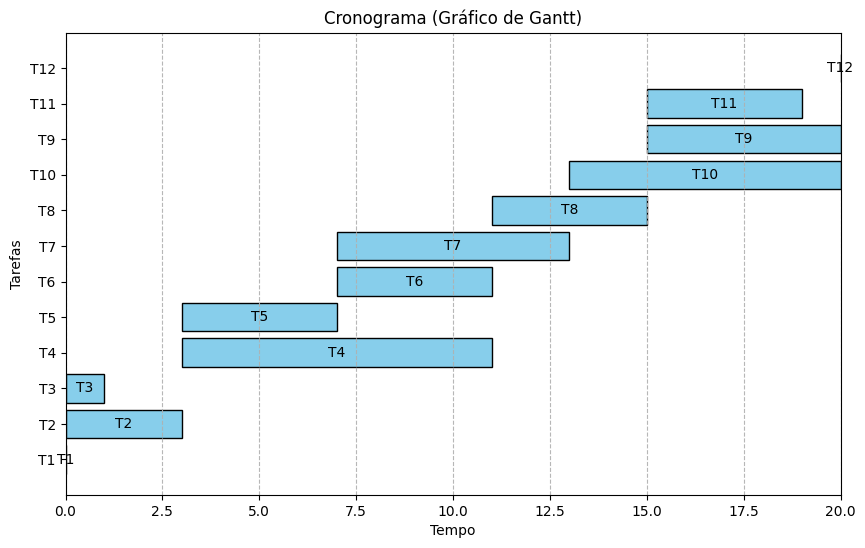

In [80]:

plot_gantt_chart(basic_schedule, parsed_data["duration_and_resources"])

# Planeamento com Heurística

Utilizar o **Caminho Crítico** como uma heurística para priorizar tarefas no cronograma. O caminho crítico é a sequência de tarefas que determina o tempo total do projeto isto ajuda a reduzir o **makespan**.

---

### Exemplo de Saída

Para um grafo com:
- Tarefas: T1, T2, T3, T4
- Precedências:
  - T1 → T2, T1 → T3
  - T2 → T4, T3 → T4
- Duração:
  - T1 = 2, T2 = 3, T3 = 4, T4 = 1

O caminho crítico será `T1 → T3 → T4` com duração total de 7.

## Calcular o Caminho Crítico

In [17]:
def calculate_critical_path(precedence_relations, duration_and_resources):
    """Calcula o caminho crítico de um grafo de precedências."""
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    successors = {rel["task"]: rel["successors"] for rel in precedence_relations}

    critical_path = {}

    def path_length(task):
        if task in critical_path:
            return critical_path[task]
        if task not in successors or not successors[task]:
            critical_path[task] = durations[task]
        else:
            critical_path[task] = durations[task] + max(path_length(succ) for succ in successors[task])
        return critical_path[task]

    for task in durations:
        path_length(task)

    return sorted(critical_path, key=lambda x: -critical_path[x])

In [18]:
def calculate_critical_path(precedence_relations, duration_and_resources):
    """
    Calcula o caminho crítico do projeto.
    :param precedence_relations: Relações de precedência entre tarefas.
    :param duration_and_resources: Duração de cada tarefa.
    :return: Lista com o caminho crítico.
    """
    # Criar dicionários para as durações e predecessores
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    predecessors = {rel["task"]: [] for rel in precedence_relations}

    for rel in precedence_relations:
        for successor in rel["successors"]:
            if successor in predecessors:
                predecessors[successor].append(rel["task"])

    # Calcular a duração acumulada para cada tarefa
    accumulated_durations = {task: 0 for task in durations.keys()}

    def calculate_accumulated_time(task):
        """
        Calcula recursivamente o tempo acumulado até a tarefa atual.
        """
        if accumulated_durations[task] > 0:  # Já calculado
            return accumulated_durations[task]
        if not predecessors[task]:  # Sem predecessores
            accumulated_durations[task] = durations[task]
        else:
            accumulated_durations[task] = durations[task] + max(
                calculate_accumulated_time(pred) for pred in predecessors[task]
            )
        return accumulated_durations[task]

    # Calcular o tempo acumulado para todas as tarefas
    for task in durations.keys():
        calculate_accumulated_time(task)

    # Identificar a tarefa final (maior duração acumulada)
    max_duration = max(accumulated_durations.values())
    end_task = max(accumulated_durations, key=accumulated_durations.get)

    # Construir o caminho crítico de trás para frente
    critical_path = []

    def build_critical_path(task):
        """
        Constrói o caminho crítico a partir da tarefa final.
        """
        if task in critical_path:
            return
        critical_path.insert(0, task)  # Adicionar no início
        for pred in predecessors.get(task, []):
            if accumulated_durations[pred] + durations[task] == accumulated_durations[task]:
                build_critical_path(pred)

    # Construir o caminho crítico começando da tarefa final
    build_critical_path(end_task)

    return critical_path




In [19]:
# Calcular o Caminho Crítico
critical_path = calculate_critical_path(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"]
)

# Exibir o Caminho Crítico
print("Caminho Crítico Corrigido:", critical_path)


Caminho Crítico Corrigido: [1, 2, 5, 7, 10]


## Heurística do Caminho Crítico

In [20]:
def plan_tasks_critical_path(precedence_relations, duration_and_resources, resource_availability, horizon):
    """Planeamento baseado no Caminho Crítico."""
    critical_path = calculate_critical_path(precedence_relations, duration_and_resources)
    print("Caminho Crítico:", critical_path)
    return create_basic_schedule(precedence_relations, duration_and_resources, resource_availability, horizon)

# Planeamento usando o Caminho Crítico
critical_path_schedule = plan_tasks_critical_path(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

Caminho Crítico: [1, 2, 5, 7, 10]


In [21]:
def parsed_data_critical_path(critical_path, parsed_data):
    """
    Reorganiza os dados de acordo com o caminho crítico calculado.
    
    :param critical_path: Lista de tarefas no caminho crítico.
    :param parsed_data: Estrutura original com informações das tarefas.
    :return: Dados organizados para o caminho crítico.
    """
    # Dicionário original das durações e recursos
    duration_and_resources = parsed_data["duration_and_resources"]
    precedence_relations = parsed_data["precedence_relations"]

    # Reorganizar os dados baseados no caminho crítico
    critical_path_data = []
    for task in critical_path:
        # Buscar informações da tarefa
        task_info = next((d for d in duration_and_resources if d["task"] == task), None)
        if task_info:
            critical_path_data.append({
                "task": task,
                "duration": task_info["duration"],
                "resources": task_info["resources"],
                "successors": next((rel["successors"] for rel in precedence_relations if rel["task"] == task), [])
            })

    # Retornar dados reorganizados para o caminho crítico
    return {
        "critical_path": critical_path,
        "tasks": critical_path_data,
        "precedence_relations": precedence_relations,
        "duration_and_resources": duration_and_resources
    }


In [22]:
# Gerar os dados organizados para o caminho crítico
critical_path_data = parsed_data_critical_path(critical_path, parsed_data)

# Apresentar os dados
import json
print("Dados do Caminho Crítico:")
print(json.dumps(critical_path_data, indent=4))

Dados do Caminho Crítico:
{
    "critical_path": [
        1,
        2,
        5,
        7,
        10
    ],
    "tasks": [
        {
            "task": 1,
            "duration": 0,
            "resources": {
                "R1": 0,
                "R2": 0
            },
            "successors": [
                2,
                3,
                4
            ]
        },
        {
            "task": 2,
            "duration": 3,
            "resources": {
                "R1": 6,
                "R2": 2
            },
            "successors": [
                5,
                6
            ]
        },
        {
            "task": 5,
            "duration": 4,
            "resources": {
                "R1": 0,
                "R2": 4
            },
            "successors": [
                7,
                8
            ]
        },
        {
            "task": 7,
            "duration": 6,
            "resources": {
                "R1": 2,
                "R

In [23]:
def validate_critical_path(precedence_relations, critical_path):
    """
    Valida se o caminho crítico respeita as precedências.
    :param precedence_relations: Relações de precedência.
    :param critical_path: Caminho crítico calculado.
    :return: True se válido, False caso contrário.
    """
    precedence_dict = {rel["task"]: rel["successors"] for rel in precedence_relations}

    for i in range(len(critical_path) - 1):
        current_task = critical_path[i]
        next_task = critical_path[i + 1]
        if next_task not in precedence_dict.get(current_task, []):
            print(f"Erro: A tarefa {next_task} não é sucessora direta de {current_task}")
            return False
    print("Validação do Caminho Crítico: Válida")
    return True

# Validar o Caminho Crítico
is_valid = validate_critical_path(parsed_data["precedence_relations"], critical_path)
print("Caminho Crítico é válido?", is_valid)


Validação do Caminho Crítico: Válida
Caminho Crítico é válido? True


## Validar Caminho Crítico

In [24]:
def validate_critical_path_order(critical_path, precedence_relations):
    """Valida se o caminho crítico respeita as precedências."""
    precedence_dict = {rel["task"]: rel["successors"] for rel in precedence_relations}
    for i in range(len(critical_path) - 1):
        current_task = critical_path[i]
        next_task = critical_path[i + 1]
        if next_task not in precedence_dict.get(current_task, []):
            print(f"Erro: A tarefa {next_task} não é sucessora direta de {current_task}")
            return False
    print("Validação do Caminho Crítico: Válida")
    return True

# Validação
validate_critical_path_order(
    critical_path=calculate_critical_path(
        parsed_data["precedence_relations"], parsed_data["duration_and_resources"]
    ),
    precedence_relations=parsed_data["precedence_relations"]
)


Validação do Caminho Crítico: Válida


True

## Construir cronograma

In [25]:
def build_schedule(critical_path, precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Constrói um cronograma baseado no caminho crítico.
    :param critical_path: Lista de tarefas no caminho crítico.
    :param precedence_relations: Relações de precedência entre tarefas.
    :param duration_and_resources: Informações de duração e recursos de cada tarefa.
    :param resource_availability: Recursos disponíveis por unidade de tempo.
    :param horizon: Horizonte de tempo definido.
    :return: Cronograma com o tempo de início de cada tarefa.
    """
    # Inicializar estruturas
    schedule = {}
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    resources = {d["task"]: d["resources"] for d in duration_and_resources}

    # Planejar tarefas do caminho crítico
    for task in critical_path:
        duration = durations[task]
        task_resources = resources[task]

        # Encontrar o primeiro intervalo de tempo disponível
        start_time = 0
        while start_time < horizon:
            is_feasible = True
            for t in range(start_time, start_time + duration):
                if t >= horizon:  # Fora do horizonte
                    is_feasible = False
                    break
                for r, amount in task_resources.items():
                    if resource_usage[r][t] + amount > resource_availability[r]:
                        is_feasible = False
                        break
                if not is_feasible:
                    break

            if is_feasible:
                # Atualizar uso de recursos
                for t in range(start_time, start_time + duration):
                    for r, amount in task_resources.items():
                        resource_usage[r][t] += amount
                schedule[task] = start_time
                break
            start_time += 1

    # Planejar tarefas não críticas
    all_tasks = {rel["task"] for rel in precedence_relations}
    non_critical_tasks = all_tasks - set(critical_path)
    for task in non_critical_tasks:
        duration = durations[task]
        task_resources = resources[task]

        # Encontrar o primeiro intervalo de tempo disponível respeitando predecessores
        start_time = 0
        predecessors = [
            rel["task"]
            for rel in precedence_relations
            if task in rel["successors"]
        ]
        if predecessors:
            start_time = max(schedule[pred] + durations[pred] for pred in predecessors)

        while start_time < horizon:
            is_feasible = True
            for t in range(start_time, start_time + duration):
                if t >= horizon:
                    is_feasible = False
                    break
                for r, amount in task_resources.items():
                    if resource_usage[r][t] + amount > resource_availability[r]:
                        is_feasible = False
                        break
                if not is_feasible:
                    break

            if is_feasible:
                # Atualizar uso de recursos
                for t in range(start_time, start_time + duration):
                    for r, amount in task_resources.items():
                        resource_usage[r][t] += amount
                schedule[task] = start_time
                break
            start_time += 1

    return schedule


In [44]:
def build_schedule(critical_path, precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Constrói um cronograma estrito respeitando todas as restrições de precedência e recursos.
    :param critical_path: Lista de tarefas no caminho crítico.
    :param precedence_relations: Relações de precedência entre tarefas.
    :param duration_and_resources: Informações de duração e recursos de cada tarefa.
    :param resource_availability: Recursos disponíveis por unidade de tempo.
    :param horizon: Horizonte de tempo definido.
    :return: Cronograma com o tempo de início de cada tarefa.
    """
    # Inicializar estruturas
    schedule = {}
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    resources = {d["task"]: d["resources"] for d in duration_and_resources}

    def can_schedule(task, start_time):
        """Valida se a tarefa pode ser agendada no tempo especificado."""
        duration = durations[task]
        task_resources = resources[task]
        for t in range(start_time, start_time + duration):
            if t >= horizon:  # Fora do horizonte
                return False
            for r, amount in task_resources.items():
                if resource_usage[r][t] + amount > resource_availability[r]:
                    return False
        return True

    def apply_schedule(task, start_time):
        """Aplica o agendamento da tarefa atualizando o uso de recursos."""
        duration = durations[task]
        task_resources = resources[task]
        for t in range(start_time, start_time + duration):
            for r, amount in task_resources.items():
                resource_usage[r][t] += amount
        schedule[task] = start_time

    # Planejar tarefas do caminho crítico
    for task in critical_path:
        start_time = 0
        while not can_schedule(task, start_time):
            start_time += 1
        apply_schedule(task, start_time)

    # Planejar tarefas não críticas
    all_tasks = {rel["task"] for rel in precedence_relations}
    non_critical_tasks = all_tasks - set(critical_path)
    for task in non_critical_tasks:
        start_time = 0
        predecessors = [
            rel["task"]
            for rel in precedence_relations
            if task in rel["successors"]
        ]
        if predecessors:
            start_time = max(schedule[pred] + durations[pred] for pred in predecessors)

        while not can_schedule(task, start_time):
            start_time += 1
        apply_schedule(task, start_time)

    return schedule

In [45]:
# Construir o cronograma
schedule = build_schedule(
    critical_path=critical_path,
    precedence_relations=parsed_data["precedence_relations"],
    duration_and_resources=parsed_data["duration_and_resources"],
    resource_availability=parsed_data["resource_availability"],
    horizon=parsed_data["general_info"]["horizon"]
)

# Exibir o Cronograma
print("Cronograma Final:")
for task, start_time in sorted(schedule.items()):
    print(f"Tarefa {task}: Início no tempo {start_time}")


Cronograma Final:
Tarefa 1: Início no tempo 0
Tarefa 2: Início no tempo 0
Tarefa 3: Início no tempo 0
Tarefa 4: Início no tempo 9
Tarefa 5: Início no tempo 3
Tarefa 6: Início no tempo 14
Tarefa 7: Início no tempo 3
Tarefa 8: Início no tempo 18
Tarefa 9: Início no tempo 22
Tarefa 10: Início no tempo 7
Tarefa 11: Início no tempo 22
Tarefa 12: Início no tempo 27


In [46]:
def validate_resource_constraints(schedule, duration_and_resources, resource_availability, horizon):
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
    
    for task, start_time in schedule.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        duration = task_info["duration"]
        resources_needed = task_info["resources"]
        
        for t in range(start_time, start_time + duration):
            for r, amount in resources_needed.items():
                resource_usage[r][t] += amount
                if resource_usage[r][t] > resource_availability[r]:
                    print(f"Erro: Recurso {r} excedido no tempo {t} pela Tarefa {task}")
                    return False
    
    print("Validação de Recursos: Todos os recursos respeitados.")
    return True

validate_resource_constraints(
    schedule,
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)


Validação de Recursos: Todos os recursos respeitados.


True

In [47]:
def validate_precedences(schedule, precedence_relations, duration_and_resources):
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            task_end_time = schedule[task] + next(
                d["duration"] for d in duration_and_resources if d["task"] == task
            )
            if schedule[successor] < task_end_time:
                print(f"Erro: Precedência violada entre Tarefa {task} -> Tarefa {successor}")
                return False
    print("Validação de Precedências: Todas as precedências respeitadas.")
    return True

validate_precedences(
    schedule,
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"]
)


Erro: Precedência violada entre Tarefa 5 -> Tarefa 7


False

In [48]:
def validate_horizon(schedule, duration_and_resources, horizon):
    for task, start_time in schedule.items():
        duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
        if start_time + duration > horizon:
            print(f"Erro: Tarefa {task} excede o horizonte de tempo.")
            return False
    print("Validação do Horizonte: Respeitado.")
    return True

validate_horizon(
    schedule,
    parsed_data["duration_and_resources"],
    parsed_data["general_info"]["horizon"]
)


Validação do Horizonte: Respeitado.


True

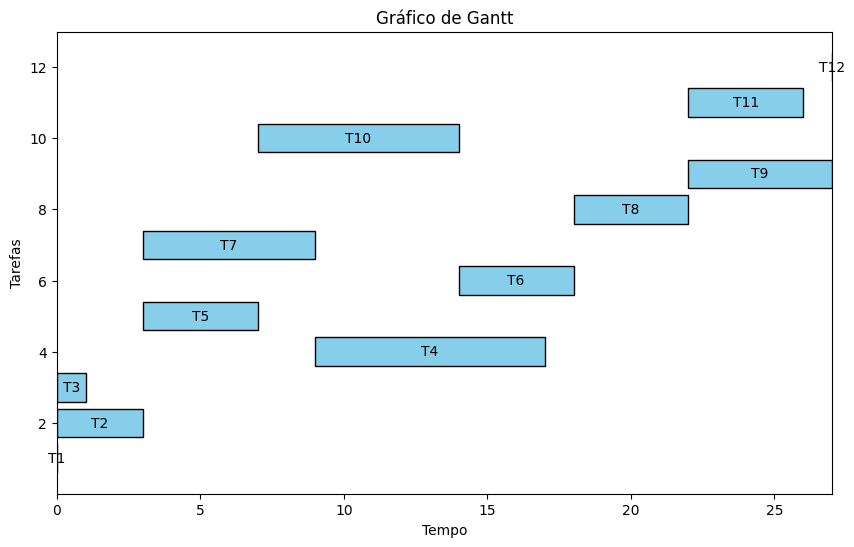

In [49]:
# Gerar o gráfico
plot_gantt_chart(schedule, parsed_data["duration_and_resources"])

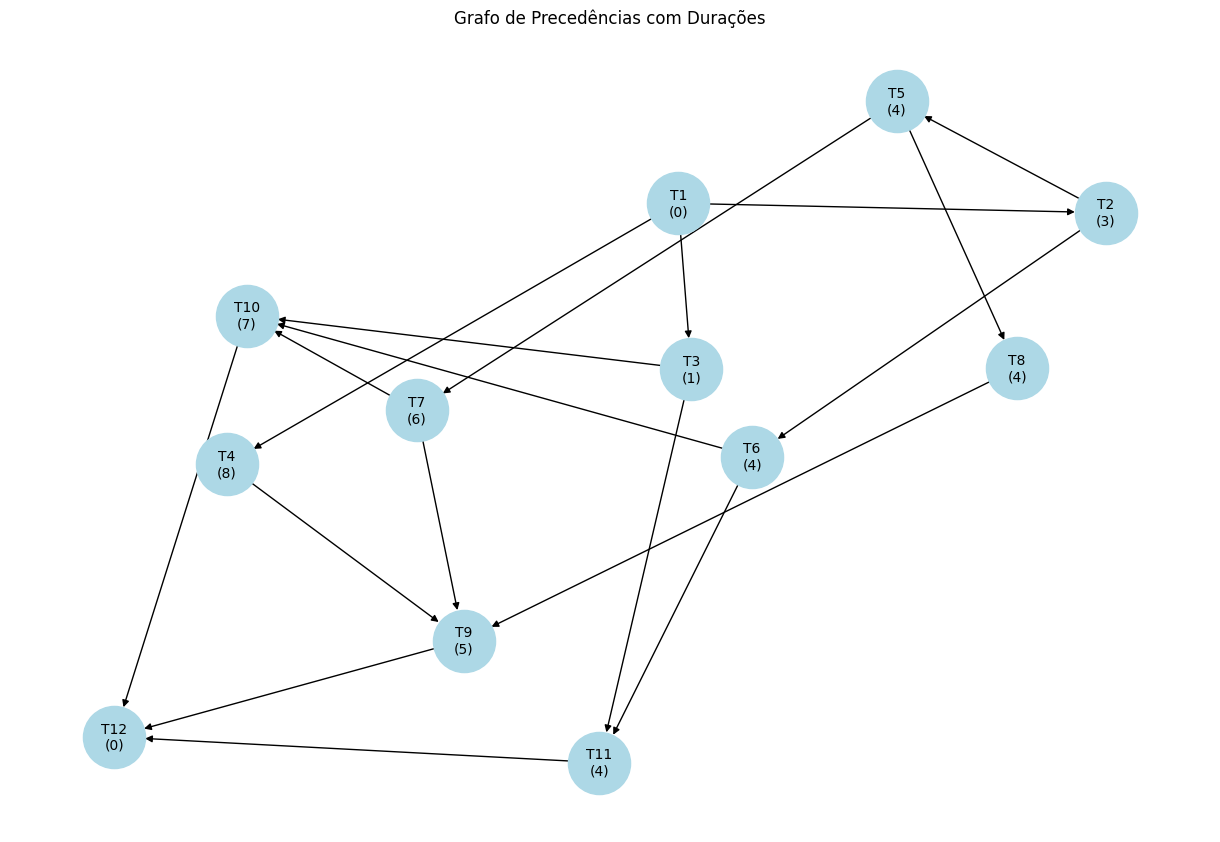

In [50]:
# Visualizar o grafo com durações anotadas
def plot_precedence_graph_with_durations(precedence_relations, duration_and_resources):
    """Plota o grafo de precedências com as durações anotadas."""
    G = nx.DiGraph()
    durations = {d["task"]: d["duration"] for d in duration_and_resources}

    # Adicionar arestas
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            G.add_edge(task, successor)

    # Configurar os rótulos dos nós com as durações
    node_labels = {task: f"T{task}\n({durations[task]})" for task in G.nodes}

    # Plotar o grafo
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue', node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): "" for u, v in G.edges})
    plt.title("Grafo de Precedências com Durações")
    plt.show()

# Plotar o grafo
plot_precedence_graph_with_durations(
    critical_path_data["precedence_relations"],
    critical_path_data["duration_and_resources"]
)

## Cronograma

In [51]:

print("Cronograma (Caminho Crítico):")
for task, start_time in critical_path_schedule.items():
    print(f"Tarefa {task}: Início {start_time}")

Cronograma (Caminho Crítico):
Tarefa 1: Início 0
Tarefa 2: Início 0
Tarefa 3: Início 0
Tarefa 4: Início 3
Tarefa 5: Início 3
Tarefa 6: Início 7
Tarefa 7: Início 7
Tarefa 8: Início 11
Tarefa 9: Início 15
Tarefa 10: Início 13
Tarefa 11: Início 15
Tarefa 12: Início 20


# Planeamento com Algoritmo A*

Criar um cronograma com recurso ao **Algoritmo A***. Este algoritmo encontra soluções otimizadas usando uma função de avaliação que combina:
1. **Custo acumulado**: Tempo total até o momento.
2. **Heurística**: Soma das durações das tarefas restantes como estimativa.


## Implementar Algoritmo A*

In [52]:
import time
import heapq
from itertools import count

def a_star_scheduler(precedence_relations, duration_and_resources, resource_availability, horizon):
    durations = {d["task"]: d["duration"] for d in duration_and_resources}
    resources = {d["task"]: d["resources"] for d in duration_and_resources}
    successors = {rel["task"]: rel["successors"] for rel in precedence_relations}

    def heuristic(state):
        remaining_tasks = set(durations.keys()) - set(state["completed_tasks"])
        return sum(durations[task] for task in remaining_tasks)

    initial_state = {
        "time": 0,
        "completed_tasks": [],
        "schedule": {},
        "resource_usage": {r: [0] * horizon for r in resource_availability}
    }

    frontier = []
    heapq.heapify(frontier)
    counter = count()
    heapq.heappush(frontier, (0, next(counter), initial_state))

    start_time = time.time()
    while frontier:
        if time.time() - start_time > 300:  # Limitar execução a 60 segundos
            print("Execução interrompida por limite de tempo.")
            return None

        _, _, current_state = heapq.heappop(frontier)

        if len(current_state["completed_tasks"]) == len(durations):
            print("Cronograma encontrado!")
            return current_state["schedule"]

        for task in durations.keys():
            if task in current_state["completed_tasks"]:
                continue

            predecessors = [
                pred for pred, rel in successors.items() if task in rel
            ]
            if any(pred not in current_state["completed_tasks"] for pred in predecessors):
                continue

            start_time_task = max(
                max(
                    (current_state["schedule"].get(pred, 0) + durations[pred] for pred in predecessors if pred in current_state["schedule"]),
                    default=0
                ),
                current_state["time"]
            )

            duration = durations[task]
            resources_needed = resources[task]
            is_feasible = True

            for t in range(start_time_task, start_time_task + duration):
                if t >= horizon:
                    is_feasible = False
                    break
                for r, amount in resources_needed.items():
                    if current_state["resource_usage"][r][t] + amount > resource_availability[r]:
                        is_feasible = False
                        break
                if not is_feasible:
                    break

            if not is_feasible:
                continue

            new_resource_usage = {
                r: usage.copy() for r, usage in current_state["resource_usage"].items()
            }
            for t in range(start_time_task, start_time_task + duration):
                for r, amount in resources_needed.items():
                    new_resource_usage[r][t] += amount

            new_state = {
                "time": start_time_task + duration,
                "completed_tasks": current_state["completed_tasks"] + [task],
                "schedule": {**current_state["schedule"], task: start_time_task},
                "resource_usage": new_resource_usage
            }

            priority = new_state["time"] + heuristic(new_state)
            heapq.heappush(frontier, (priority, next(counter), new_state))

    print("Nenhum cronograma encontrado.")
    return None


In [53]:
# Executar o algoritmo A*
a_star_schedule = a_star_scheduler(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

# Exibir o cronograma gerado
print("Cronograma gerado pelo A*:")
print(a_star_schedule)


Cronograma encontrado!
Cronograma gerado pelo A*:
{1: 0, 2: 0, 3: 3, 4: 4, 5: 12, 6: 16, 7: 20, 8: 26, 9: 30, 10: 35, 11: 42, 12: 46}


In [54]:
# Validar restrições de precedência
validate_precedences(
    a_star_schedule,
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"]
)

# Validar uso de recursos
validate_resource_constraints(
    a_star_schedule,
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

# Validar horizonte de tempo
validate_horizon(
    a_star_schedule,
    parsed_data["duration_and_resources"],
    parsed_data["general_info"]["horizon"]
)


Validação de Precedências: Todas as precedências respeitadas.
Validação de Recursos: Todos os recursos respeitados.
Validação do Horizonte: Respeitado.


True

## Cronograma

In [55]:
print("Cronograma (A*):")
for task, start_time in a_star_schedule.items():
    print(f"Tarefa {task}: Início {start_time}")

Cronograma (A*):
Tarefa 1: Início 0
Tarefa 2: Início 0
Tarefa 3: Início 3
Tarefa 4: Início 4
Tarefa 5: Início 12
Tarefa 6: Início 16
Tarefa 7: Início 20
Tarefa 8: Início 26
Tarefa 9: Início 30
Tarefa 10: Início 35
Tarefa 11: Início 42
Tarefa 12: Início 46


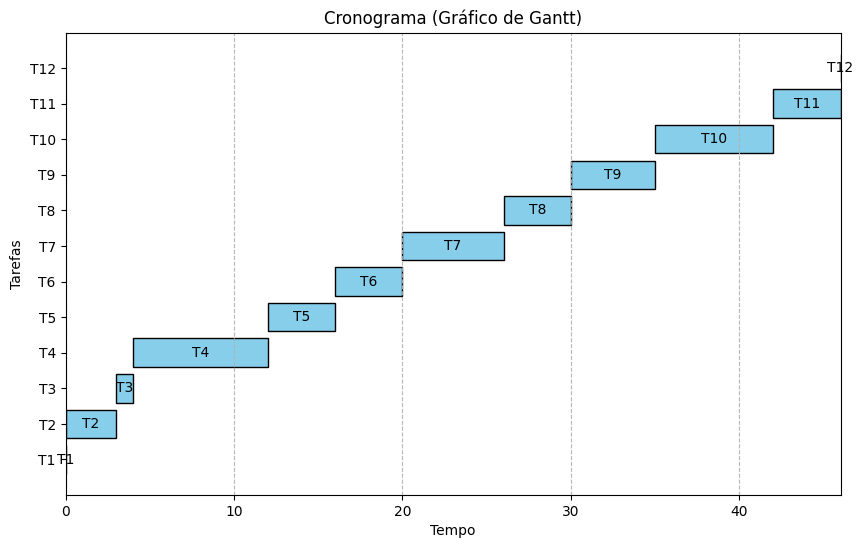

In [90]:
# Gerar o gráfico
plot_gantt_chart(a_star_schedule, parsed_data["duration_and_resources"])

# Gera um cronograma com python-constraint

In [103]:
def generate_schedule(precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Gera um cronograma válido utilizando python-constraint.
    """
    # Criar o problema
    problem = Problem()

    # Adicionar variáveis (tempo de início para cada tarefa)
    for task_info in duration_and_resources:
        task = task_info["task"]
        problem.addVariable(task, range(horizon))

    # Adicionar restrições de precedência
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            def precedence_constraint(start_task, start_successor, task=task, successor=successor):
                duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
                return start_task + duration <= start_successor
            problem.addConstraint(precedence_constraint, (task, successor))

    # Adicionar restrições de recursos
    def resource_constraint(*start_times):
        resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
        for task, start_time in enumerate(start_times, 1):
            task_info = next(d for d in duration_and_resources if d["task"] == task)
            duration = task_info["duration"]
            resources_needed = task_info["resources"]
            for t in range(start_time, start_time + duration):
                for r, amount in resources_needed.items():
                    resource_usage[r][t] += amount
                    if resource_usage[r][t] > resource_availability[r]:
                        return False
        return True

    problem.addConstraint(resource_constraint, [task_info["task"] for task_info in duration_and_resources])

    # Resolver o problema
    solution = problem.getSolution()

    if solution:
        return solution
    else:
        print("Nenhuma solução encontrada!")
        return None

# Exemplo de uso
constraint_schedule = generate_schedule(
    precedence_relations=parsed_data["precedence_relations"],
    duration_and_resources=parsed_data["duration_and_resources"],
    resource_availability=parsed_data["resource_availability"],
    horizon=parsed_data["general_info"]["horizon"]
)

print("Novo cronograma gerado:")
print(constraint_schedule)


Novo cronograma gerado:
{9: 40, 10: 38, 12: 45, 7: 32, 5: 28, 2: 25, 6: 32, 11: 41, 1: 25, 3: 37, 8: 36, 4: 28}


# Análise do Makespan

In [104]:
def calculate_makespan(planned_tasks, duration_and_resources):
    """
    Calcula o makespan (tempo total) com base nas tarefas planeadas.
    :param planned_tasks: Dicionário {tarefa: tempo de início}.
    :param duration_and_resources: Lista de dicionários com duração e recursos de cada tarefa.
    :return: Makespan (tempo total).
    """
    makespan = max(
        planned_tasks[task] + next(d["duration"] for d in duration_and_resources if d["task"] == task)
        for task in planned_tasks
    )
    return makespan

# Utilização de Recursos

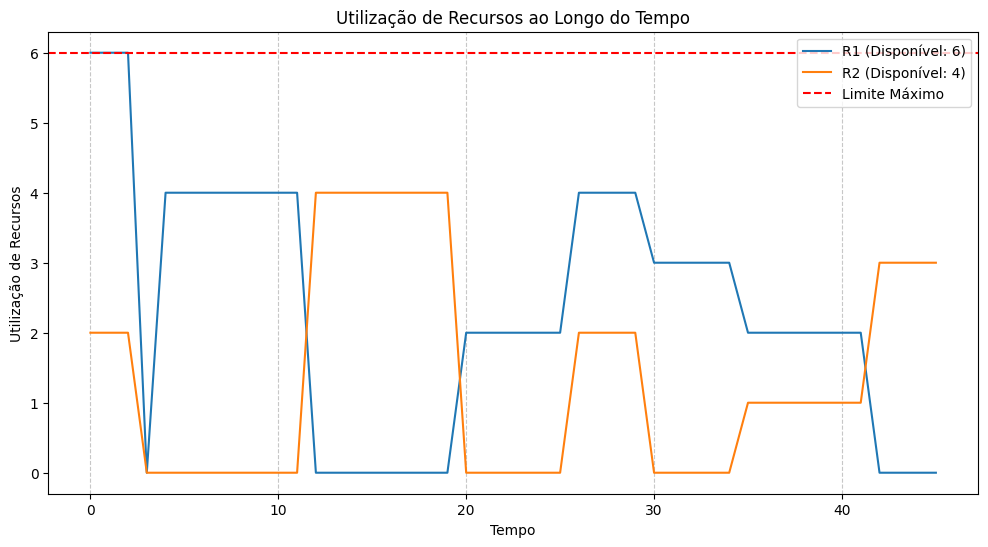

In [105]:
def plot_resource_usage(planned_tasks, duration_and_resources, resource_availability, horizon):
    """
    Gera um gráfico da utilização dos recursos ao longo do horizonte.
    :param planned_tasks: Dicionário {tarefa: tempo de início}.
    :param duration_and_resources: Lista com duração e recursos de cada tarefa.
    :param resource_availability: Dicionário com a disponibilidade total de recursos.
    :param horizon: Horizonte de tempo.
    """
    # Inicializar uso de recursos
    resource_usage = {r: [0] * horizon for r in resource_availability.keys()}

    # Preencher o uso de recursos
    for task, start_time in planned_tasks.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        duration = task_info["duration"]
        resources = task_info["resources"]
        for t in range(duration):
            for r, amount in resources.items():
                resource_usage[r][start_time + t] += amount

    # Plotar o uso de recursos
    plt.figure(figsize=(12, 6))
    for resource, usage in resource_usage.items():
        plt.plot(range(horizon), usage, label=f"{resource} (Disponível: {resource_availability[resource]})")

    plt.xlabel("Tempo")
    plt.ylabel("Utilização de Recursos")
    plt.title("Utilização de Recursos ao Longo do Tempo")
    plt.axhline(y=max(resource_availability.values()), color='r', linestyle='--', label="Limite Máximo")
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

# Gerar gráfico de utilização de recursos
plot_resource_usage(
    a_star_schedule,
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)


In [106]:
from constraint import Problem

def validate_schedule(schedule, precedence_relations, duration_and_resources, resource_availability, horizon):
    """
    Valida um cronograma gerado utilizando python-constraint.
    """
    # Criar o problema
    problem = Problem()

    # Adicionar variáveis com domínios fixos (os tempos gerados pelo algoritmo)
    for task, start_time in schedule.items():
        problem.addVariable(task, [start_time])

    # Adicionar restrições de precedência
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            def precedence_constraint(start_task, start_successor, task=task, successor=successor):
                duration = next(d["duration"] for d in duration_and_resources if d["task"] == task)
                return start_task + duration <= start_successor
            problem.addConstraint(precedence_constraint, (task, successor))

    # Adicionar restrições de recursos
    def resource_constraint(*start_times):
        resource_usage = {r: [0] * horizon for r in resource_availability.keys()}
        for task, start_time in schedule.items():
            task_info = next(d for d in duration_and_resources if d["task"] == task)
            duration = task_info["duration"]
            resources_needed = task_info["resources"]
            for t in range(start_time, start_time + duration):
                for r, amount in resources_needed.items():
                    resource_usage[r][t] += amount
                    if resource_usage[r][t] > resource_availability[r]:
                        return False
        return True

    problem.addConstraint(resource_constraint, schedule.keys())

    # Validar a solução
    solution = problem.getSolution()
    return solution is not None

# Exemplo de uso
is_valid = validate_schedule(
    schedule=a_star_schedule,
    precedence_relations=parsed_data["precedence_relations"],
    duration_and_resources=parsed_data["duration_and_resources"],
    resource_availability=parsed_data["resource_availability"],
    horizon=parsed_data["general_info"]["horizon"]
)

if is_valid:
    print("Cronograma válido!")
else:
    print("Erro: Cronograma inválido!")


Cronograma válido!


# Comparar Resultados

In [107]:
# Comparar makespan
makespan_basic = calculate_makespan(basic_schedule, parsed_data["duration_and_resources"])
makespan_critical = calculate_makespan(schedule, parsed_data["duration_and_resources"])
makespan_a_star = calculate_makespan(a_star_schedule, parsed_data["duration_and_resources"])
makespan_constraint = calculate_makespan(constraint_schedule, parsed_data["duration_and_resources"])

print(f"Makespan (Básico): {makespan_basic}")
print(f"Makespan (Caminho Crítico): {makespan_critical}")
print(f"Makespan (A*): {makespan_a_star}")
print(f"Makespan (A*): {makespan_constraint}")


Makespan (Básico): 20
Makespan (Caminho Crítico): 27
Makespan (A*): 46
Makespan (A*): 45


In [82]:
def plan_tasks_with_heuristics(precedence_relations, duration_and_resources, resource_availability, horizon):
    # Inicializar o cronograma
    schedule = initialize_schedule(horizon, resource_availability)
    planned_tasks = {}  # Tarefas já planeadas

    while len(planned_tasks) < len(duration_and_resources):
        # Encontrar tarefas não planeadas cujas predecessoras foram concluídas
        available_tasks = []
        for task_info in duration_and_resources:
            task = task_info["task"]
            if task in planned_tasks:
                continue

            # Verificar se todas as predecessoras foram concluídas
            predecessors = [
                rel["task"]
                for rel in precedence_relations
                if task in rel["successors"]
            ]
            if all(pred in planned_tasks for pred in predecessors):
                # Calcula o tempo de término das predecessoras
                max_predecessor_end_time = max(
                    planned_tasks[pred] + next(
                        d["duration"] for d in duration_and_resources if d["task"] == pred
                    )
                    for pred in predecessors
                ) if predecessors else 0

                # Adicionar a tarefa à lista de disponíveis, incluindo a informação do tempo mínimo
                available_tasks.append((task_info, max_predecessor_end_time))

        # Ordenar as tarefas disponíveis pela heurística: menor duração e mais sucessoras
        available_tasks.sort(key=lambda t: (t[0]["duration"], -len([
            rel["successors"]
            for rel in precedence_relations
            if t[0]["task"] == rel["task"]
        ])))

        # Planear a primeira tarefa disponível que respeita os recursos
        for task_info, min_start_time in available_tasks:
            task = task_info["task"]
            duration = task_info["duration"]
            resources_needed = task_info["resources"]

            # Encontrar o primeiro intervalo de tempo disponível após as predecessoras
            start_time = None
            for t in range(min_start_time, horizon - duration + 1):
                if all(
                    schedule["resource_usage"][r][t + i] + resources_needed[r] <= resource_availability[r]
                    for r in resources_needed
                    for i in range(duration)
                ):
                    start_time = t
                    break

            # Se a tarefa pode ser planeada, atualiza o cronograma
            if start_time is not None:
                for i in range(duration):
                    for r in resources_needed:
                        schedule["resource_usage"][r][start_time + i] += resources_needed[r]
                planned_tasks[task] = start_time
                break

    return planned_tasks

# Planear as tarefas com a heurística
planned_tasks = plan_tasks_with_heuristics(
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)

print("Tarefas Planeadas (com heurística):")
print(json.dumps(planned_tasks, indent=4))

Tarefas Planeadas (com heurística):
{
    "1": 0,
    "3": 0,
    "2": 0,
    "5": 3,
    "6": 7,
    "8": 11,
    "11": 15,
    "7": 7,
    "10": 13,
    "4": 3,
    "9": 15,
    "12": 20
}


In [83]:
def validate_schedule_with_resources(planned_tasks, precedence_relations, duration_and_resources, resource_availability, horizon):
    # Validar precedências
    for relation in precedence_relations:
        task = relation["task"]
        for successor in relation["successors"]:
            task_end_time = planned_tasks[task] + next(
                d["duration"] for d in duration_and_resources if d["task"] == task
            )
            if task_end_time > planned_tasks[successor]:
                print(f"Erro: Precedência violada entre {task} -> {successor}")
                return False

    # Validar recursos
    schedule = initialize_schedule(horizon, resource_availability)
    for task, start_time in planned_tasks.items():
        task_info = next(d for d in duration_and_resources if d["task"] == task)
        for t in range(task_info["duration"]):
            for r in task_info["resources"]:
                schedule["resource_usage"][r][start_time + t] += task_info["resources"][r]
                if schedule["resource_usage"][r][start_time + t] > resource_availability[r]:
                    print(f"Erro: Recursos excedidos em Tarefa {task} no tempo {start_time + t}")
                    return False

    print("Validação: Todas as restrições foram respeitadas.")
    return True

# Validar o cronograma
validate_schedule_with_resources(
    planned_tasks,
    parsed_data["precedence_relations"],
    parsed_data["duration_and_resources"],
    parsed_data["resource_availability"],
    parsed_data["general_info"]["horizon"]
)


Validação: Todas as restrições foram respeitadas.


True

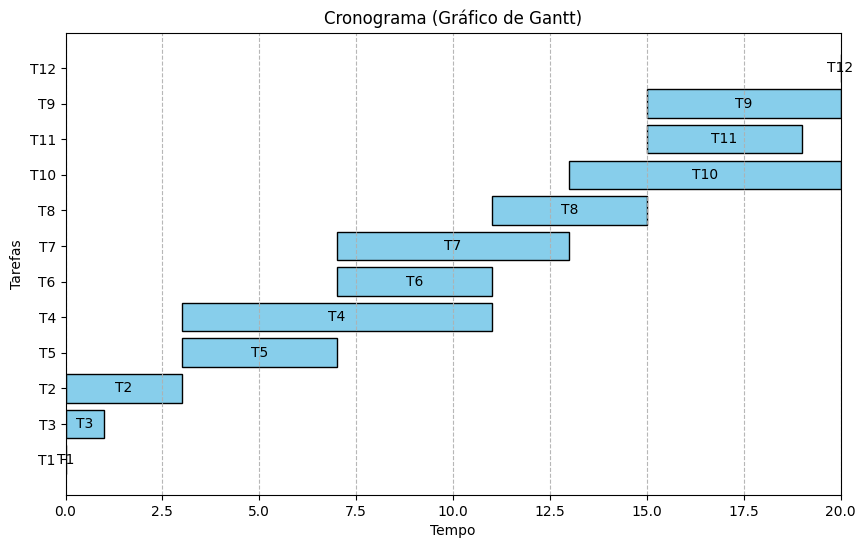

In [85]:
plot_gantt_chart(planned_tasks, parsed_data["duration_and_resources"])

# Conclusão

O desenvolvimento deste projeto permitiu aplicar conceitos fundamentais da UC de Inteligência Artificial na criação e implementação de um agente inteligente. 
Durante este processo, foi possível explorar técnicas de planeamento, otimização e resolução de problemas sob restrições, consolidando conhecimentos teóricos e práticos.
Este projeto permitiu desenvolver um agente inteligente capaz de resolver problemas de planeamento com restrições fortes e leves, garantindo soluções viáveis e otimizadas. Foram aplicados algoritmos de procura e heurísticas para atender aos objetivos definidos, enquanto ferramentas como o Jupyter Notebook facilitaram a organização e análise do mesmo. O agente demonstrou eficácia em diferentes cenários, reforçando a aplicabilidade de Inteligência Artificial na resolução de problemas práticos e complexos.